### Grading Feedback

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- Students may use toPandas() to print the head of data frames.
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.__

In [1]:
# Create Spark Session and Spark Context
from pyspark.sql import SparkSession
from pyspark.sql import Row
# Spark 1.6 (sparkContext on variable sc)
# Spark 2.0 Dataframes
import numpy as np
import pandas as pd

In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# # # # #
import seaborn as sns
from pyspark.sql import functions as fn
from pyspark.ml.stat import Correlation
from pyspark.ml import feature, regression, evaluation, Pipeline

In [3]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [4]:
# Do not delete or change this cell

import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

# Question 1
Using the get_training_filename function defined in the cell above, read the sms_spam.csv file into a spark dataframe named spam_df.  There should be no empty columns in spam_df.

In [5]:
# Your code here
spam_df = spark.read.csv(get_training_filename('sms_spam.csv'), header=True, inferSchema=True)
# print(spam_df.printSchema())
# spam_df.show(5)

In [6]:
spam_df.show(5)
print(spam_df.printSchema())

+----+--------------------+
|type|                text|
+----+--------------------+
| ham|Go until jurong p...|
| ham|Ok lar... Joking ...|
|spam|Free entry in 2 a...|
| ham|U dun say so earl...|
| ham|Nah I don't think...|
+----+--------------------+
only showing top 5 rows

root
 |-- type: string (nullable = true)
 |-- text: string (nullable = true)

None


### Grading Feedback

# Question 2
Starting with spam_df, create a new dataframe named spam_df1.  Rename the spam_df type column to be named spam.  In the spam column, replace the string `spam` the with the integer 1 and the string `ham` with the integer 0.  Print the head and shape of spam_df1.

In [7]:
# your code here
spam_df1 = spam_df.withColumnRenamed("type", "spam")
# method 2:
# spam_df1 = spam_df.select(fn.col('type').alias('spam'), fn.col("text"))

# explore the spam_df1
# spam_df1.select('spam').distinct().show()

spam_df1 = spam_df1.withColumn("spam",fn.when(fn.col("spam")=="ham", 0).otherwise(1))
print('The head of spam_df1 is:\n',spam_df1.head())
print('\n')
print('The shape of spam_df1 is: ',(spam_df1.count(),len(spam_df1.columns)))

The head of spam_df1 is:
 Row(spam=0, text='Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')


The shape of spam_df1 is:  (5574, 2)


In [8]:
spam_df1.where(fn.col('spam') == 0).count()

4827

In [9]:
spam_df1.where(fn.col('spam') == 1).count()

747

# Question 3
Starting with spam_df1, create a new dataframe named spam_df2 with a new column named filtered_text by removing stop words from the text column in spam_df.  Print the head and shape of spam_df2.

In [10]:
# your code here
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import RegexTokenizer

# the tokenizer object
# tokenizer = Tokenizer().setInputCol("text")\
#   .setOutputCol("words")
tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("text")\
  .setOutputCol("words")

# we obtain the stop words from a website
import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
from pyspark.ml.feature import StopWordsRemover
# the StopWordsRemover object
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered_text")

# we now create a pipelined transformer
swr_pipeline = Pipeline(stages=[tokenizer, sw_filter]).fit(spam_df1)
# now we can make the transformation between the raw text and the filtered_text
spam_df2=swr_pipeline.transform(spam_df1)
# spam_df2=spam_df2.drop('words')

In [11]:
print('The head of spam_df2 is:\n',spam_df2.head())
print('\n')
print('The shape of spam_df2 is: ',(spam_df2.count(),len(spam_df2.columns)))

The head of spam_df2 is:
 Row(spam=0, text='Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', words=['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat'], filtered_text=['jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat'])


The shape of spam_df2 is:  (5574, 4)


In [12]:
spam_df2.show(2)

+----+--------------------+--------------------+--------------------+
|spam|                text|               words|       filtered_text|
+----+--------------------+--------------------+--------------------+
|   0|Go until jurong p...|[go, until, juron...|[jurong, point, c...|
|   0|Ok lar... Joking ...|[ok, lar, joking,...|[ok, lar, joking,...|
+----+--------------------+--------------------+--------------------+
only showing top 2 rows



### Grading Feedback

# Question 3
Create a new dataframe named spam_df3 starting with spam_df2.  Create a new column named tfidf by performing a term frequency / inverse document frequency transformation on the filtered_text column of spam_df2.<br>  

- Print the head and shape of spam_df3.  
- Print the top 10 most important words indicated by the TFIDF score.  
- Print the 10 least important words as indicated by the TFIDF score.
- Print the total number of columns in the TFIDF data in spam_df3
- Print the number of rows in the TFIDF data in spam_df3
- Based only on the number of rows and columns in the TFIDF data, do you expect the model to overfit.  Explain your answer.

In [13]:
# Your code here
from pyspark.ml.feature import CountVectorizer
# we will remove words that appear in 5 docs or less
cv = CountVectorizer(minTF=1,minDF=5,vocabSize=2**17)\
  .setInputCol("filtered_text")\
  .setOutputCol("tf")

from pyspark.ml.feature import IDF
idf = IDF().setInputCol("tf").setOutputCol("tfidf")

#cv_fitted=Pipeline(stages=[cv]).fit(spam_df2)

#idf_fitted=Pipeline(stages=[cv_fitted,idf]).fit(spam_df2)

idf_pipeline = Pipeline(stages=[cv,idf]).fit(spam_df2)

spam_df3=idf_pipeline.transform(spam_df2)

# spam_df3=spam_df3.drop('tf')

In [14]:
spam_df3.limit(2).toPandas()

,spam,text,words,filtered_text,tf,tfidf
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...","[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, cine, there, got, amore, wat]","[jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.1879682874051243, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.649313853907745, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.934699714099176, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.9913186080986836, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.148710781850113, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","(1.8914559363553713, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9912579931590697, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [15]:
# Print the head and shape of spam_df3.
print('Q3 1.1 The head of spam_df3 is:\n',spam_df3.head(),'\n')
print('Q3 1.2 The shape of spam_df3 is: ',(spam_df3.count(),len(spam_df3.columns)))

Q3 1.1 The head of spam_df3 is:
 Row(spam=0, text='Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', words=['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat'], filtered_text=['jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat'], tf=SparseVector(1550, {15: 1.0, 26: 1.0, 53: 1.0, 61: 1.0, 68: 1.0, 208: 1.0, 486: 1.0, 567: 1.0, 646: 1.0, 832: 1.0, 1065: 1.0, 1099: 1.0}), tfidf=SparseVector(1550, {15: 3.188, 26: 3.6493, 53: 3.9347, 61: 3.9913, 68: 4.1487, 208: 5.0425, 486: 5.6816, 567: 5.918, 646: 5.987, 832: 6.2282, 1065: 6.5466, 1099: 6.5466})) 

Q3 1.2 The shape of spam_df3 is:  (5574, 6)


In [16]:
# spam_df3.toPandas().loc[:1, ['tf', 'tfidf']]

In [17]:
vocabulary = idf_pipeline.stages[0].vocabulary
tfidf = idf_pipeline.stages[1].idf.toArray()
tfidf_df = pd.DataFrame({'word': vocabulary, 'tfidf': tfidf})
# Print the total number of columns in the TFIDF data in spam_df3

In [18]:
# Print the top 10 most important words indicated by the TFIDF score.
print('Q3 2. The top 10 most important words indicated by the TFIDF score are:\n')
tfidf_df.sort_values('tfidf',ascending=False).head(10)

Q3 2. The top 10 most important words indicated by the TFIDF score are:



,word,tfidf
1549,geeee,6.834288
1396,flat,6.834288
1408,sam,6.834288
1407,nat,6.834288
1406,bcm,6.834288
1405,inclusive,6.834288
1404,arrested,6.834288
1403,nw,6.834288
1401,broke,6.834288
1400,asleep,6.834288


In [19]:
# Print the 10 least important words as indicated by the TFIDF score.
print('Q3 3. The 10 least important words indicated by the TFIDF score are:\n')
tfidf_df.sort_values('tfidf').head(10)
# tfidf_df.sort_values(abs('tfidf')).head(10)

Q3 3. The 10 least important words indicated by the TFIDF score are:



,word,tfidf
0,u,1.891456
1,s,2.366466
3,m,2.576314
2,t,2.602600
5,just,2.737170
4,ur,2.895948
8,ok,2.991258
10,ll,3.073088
11,know,3.116659
7,lt,3.132986


In [20]:
# Print the total number of columns in the TFIDF data in spam_df3
# Print the number of rows in the TFIDF data in spam_df3

print('Q3 4. The total number of columns in the TFIDF data in spam_df3 is:\n',len(tfidf))
# Print the number of rows in the TFIDF data in spam_df3
print('Q3 5. The number of rows in the TFIDF data in spam_df3 is:\n',spam_df3.count())

Q3 4. The total number of columns in the TFIDF data in spam_df3 is:
 1550
Q3 5. The number of rows in the TFIDF data in spam_df3 is:
 5574


Your model overfit explanation here:

Based only on the number of rows and columns in the TFIDF data, I expect the model to overfit. <br/>
When the number of features is bigger than that of training examples, the model tends to overfit. Though in our dataset, the number of features is smaller than that of training examples, we still have too many features. Since the variance of a regression model is directly proportional to the number of features in the data set: as number of  features increases, model variance increases. High variance means that our learning algorithm varies a lot depending on the training data. This is bad because it means our algorithm is probably not robust to noise for example and it will fail to generalize to new examples.

### Grading Feedback

# Question 4
Create a pipeline named pipe1 capable of predicting ham or spam using logistic regression using spam_df3 as input data.

In [21]:
# your code here
from pyspark.ml.classification import LogisticRegression

lr=LogisticRegression().\
    setLabelCol('spam').\
    setFeaturesCol('tfidf').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)
pipe1=Pipeline(stages=[lr])

### Grading Feedback

# Question 5
Fit pipe1 using a [CrossValidator](https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) object with the number of cross validation folds = 3.  Score the model using a [BinaryClassificationEvaluator](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html) using ROC AUC as the metric.  Name the cross validator object cv1 and the fitted cross validator object fitted_cv1.

In [22]:
training_df, testing_df = spam_df3.randomSplit([0.8, 0.2], seed=0)

In [23]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [24]:
# Define a grid search ParamGridBuilder object. 
# elasticNetParam and regParam are 0
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.]) \
    .addGrid(lr.regParam, [0.]) \
    .build()
# The length of the grid is 1 because it implements all combinations of elasticNetParam (1 option) and regParam (1 options).
len(paramGrid)

1

In [25]:
# your code here
# Define an evaluator 
evaluator = BinaryClassificationEvaluator(labelCol=lr.getLabelCol(), rawPredictionCol=lr.getRawPredictionCol())
# create a CrossValidator object with the number of cross validation folds = 3
cv1=CrossValidator(estimator=pipe1,
                   estimatorParamMaps=paramGrid, 
                   evaluator=evaluator,
                   numFolds=3)

In [26]:
# Fit cv1 using the CrossValidator object with the number of cross validation folds = 3
fitted_cv1 = cv1.fit(training_df)

In [27]:
# Let's look at the performance
fitted_cv1.transform(testing_df).select(fn.expr('float(prediction=spam)').alias('correct')).select(fn.avg('correct')).show()

+------------------+
|      avg(correct)|
+------------------+
|0.9582608695652174|
+------------------+



In [28]:
# Score the model using a BinaryClassificationEvaluator using ROC AUC as the metric.
evaluator.evaluate(fitted_cv1.transform(testing_df))

0.940023467013914

In [29]:
# the Evaluator gives us AUC as the metric.
evaluator.getMetricName()

'areaUnderROC'

### Grading Feedback

# Question 6
Print the cross validation AUC score from fitted_cv1.

In [30]:
# Score the model using a BinaryClassificationEvaluator using ROC AUC as the metric.
evaluator.evaluate(fitted_cv1.transform(testing_df))

0.940023467013914

In [31]:
# the Evaluafrom pyspark.mllib.evaluation import BinaryClassificationMetricstor gives us AUC as the metric.
evaluator.getMetricName()

'areaUnderROC'

In [32]:
# the cross validation AUC score from fitted_cv1.
auc = fitted_cv1.bestModel.stages[-1].summary.areaUnderROC
auc

0.9995850767085076

### Grading Feedback

# Question 7
Create a ROC scatter plot from fitted_pipe1 TPR/FPR data.

In [33]:
roc = fitted_cv1.bestModel.stages[-1].summary.roc
# method 2:
# fpr = fitted_cv1.bestModel.stages[-1].summary.roc.select('FPR').toPandas()
# tpr = fitted_cv1.bestModel.stages[-1].summary.roc.select('TPR').toPandas()

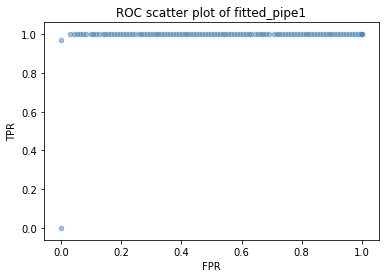

In [34]:
# your code here
roc.select('FPR','TPR'). \
 toPandas().plot(x='FPR',y='TPR',kind='scatter', \
                                 color='steelblue',alpha=0.5, \
                                 title="ROC scatter plot of fitted_pipe1");

### Grading Feedback

# Question 8
Create a new cross validator object named cv2 similar to cv1 but this time add a ParamGridBuilder.  Define a grid of elastic net regularization parameters. Fit cv2 and name the resulting fitted cross validator fitted_cv2.  The number of parameters in your grid should be limited such that it runs in a reasonable amount of time (around 5 to 10 minutes max).  

In [35]:
# your code here
# elasticNetParam corresponds to α and regParam corresponds to λ
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.01, 0.02, 0.2]) \
    .addGrid(lr.regParam, [0.01, 0.02, 0.05, 0.2]) \
    .build()

In [36]:
# your code here
# Create a new cross validator object named cv2  
cv2=CrossValidator(estimator=pipe1,
                   estimatorParamMaps=paramGrid, 
                   evaluator=evaluator,
                   numFolds=3)

In [37]:
# Fit cv2 and name the resulting fitted cross validator fitted_cv2. 
fitted_cv2 = cv2.fit(training_df)

### Grading feedback

# Question 9
- Print the resulting AUC from fitted_cv2. 
- Print the best model's L1 and L2 regularization parameters
- Analyze the L1 feature selection:
    - Print the total number of features
    - Print the number of features that L1 regularization eliminated
    - If any features were eliminated, print a sample of 10 words that were eliminated

In [38]:
best_model=fitted_cv2.bestModel

In [39]:
# your code here
# Print the resulting AUC from fitted_cv2.
print('the resulting AUC from fitted_cv2 is:') 
print(evaluator.evaluate(fitted_cv2.transform(testing_df)))

the resulting AUC from fitted_cv2 is:
0.9916678535821002


In [43]:
# Print the best model's L1 and L2 regularization parameters
# elasticNetParam corresponds to α 
# regParam corresponds to λ
# print(best_model.stages[0].getElasticNetParam())
# print(best_model.stages[0].getRegParam())
print("best model's Elastic Net regularization parameter is:\n",best_model.stages[0].getRegParam())
print("best model's L1 regularization parameter is:\n",(best_model.stages[0].getRegParam())*(best_model.stages[0].getElasticNetParam()))
print("best model's L2 regularization parameters is:\n",(1-best_model.stages[0].getRegParam())*(best_model.stages[0].getElasticNetParam()))

best model's Elastic Net regularization parameter is:
 0.05
best model's L1 regularization parameter is:
 0.0005
best model's L2 regularization parameters is:
 0.0095


In [47]:
# Print the total number of features 
en_weights = best_model.stages[0].coefficients.toArray()
en_weights = fitted_cv2.bestModel.stages[0].coefficients.toArray()
print("The total number of features is:\n",en_weights.shape[0])

The total number of features is:
 1550


In [48]:
en_coeffs_df = pd.DataFrame({'word': vocabulary, 'weight': en_weights})

In [49]:
# Print the number of features that L1 regularization eliminated
print("the number of features that L1 regularization eliminated is:\n",en_coeffs_df.query('weight == 0.0').shape[0])

the number of features that L1 regularization eliminated is:
 265


In [50]:
# print a sample of 10 words that were eliminated
print("a sample of 10 words that were eliminated:")
en_coeffs_df.query('weight == 0.0').head(10)

a sample of 10 words that were eliminated:


,word,weight
1,s,0.0
2,t,0.0
5,just,0.0
27,r,0.0
28,need,0.0
42,hi,0.0
53,great,0.0
64,make,0.0
68,e,0.0
85,meet,0.0


### Grading Feedback

# Question 10
Analyze the best model weights in fitted_cv2.  Print the 10 words that contribute the most to predicting spam.  Print the 10 words that contribute the least to predicting spam.  Do the words make sense?  Explain.

In [51]:
# your code here
weights=best_model.stages[0].coefficients.toArray()
coeffs_df = pd.DataFrame({'word': vocabulary, 'weight': weights})

In [52]:
# weights=bestModel.stages[0].coefficients.toArray()
# coeffs_df = pd.DataFrame({'word': vocabulary, 'weight': weights})

In [53]:
# Print the 10 words that contribute the most to predicting spam
print("The 10 words that contribute the most to predicting spam are:")
coeffs_df.sort_values('weight', ascending=False).head(10)

The 10 words that contribute the most to predicting spam are:


,word,weight
979,freephone,0.586449
1246,ls,0.513573
1223,ladies,0.503092
256,ringtone,0.481544
698,pass,0.475982
975,sale,0.472165
490,services,0.471742
409,http,0.431508
504,choose,0.429764
43,new,0.423926


In [54]:
print("The 10 words that contribute the least to predicting spam are:")
coeffs_df.sort_values('weight',ascending=True).head(10)

The 10 words that contribute the least to predicting spam are:


,word,weight
1055,list,-0.237517
988,fullonsms,-0.224931
1072,looks,-0.182330
973,cheers,-0.178686
743,remove,-0.172226
1495,asks,-0.132008
934,mode,-0.131682
1095,liked,-0.123799
483,second,-0.121795
328,mail,-0.119250


Your comments here: <br/>
<br/>
For the 10 words that contribute the most to predicting spam, some of them make sense to me. <br/>For example, words like "freephone","sale","services","new" are commonly used word in SMS advertising. While word "http" are used in scam SMSs to direct the SMS receivers to some suspicious website.<br/>
<br/>
For the 10 words that contribute the least to predicting spam. They make sense to me too. <br/>
I think the words that contribute the least to predicting spam would be some everyday vocabulary and most of these words are common expressions. <br/>
However, the word "fullonsms" is an internet based portal which allows the customer to send free and unlimited messaging service to any mobile phone around India. I do not think this word is an everyday word.

### Grading Feedback

**Extra Credit (5 pts)**  This question is optional.  If you choose to answer this question, you will earn 5 extra credit points.  If you choose not to answer this question, no points will be deducted from your score.  Solve the following equation for $c$ symbolically using the python sympy package.  Convert the solved symbolic solution to a latex format (this can be done with a pyton call), then populate the solution cell with the resulting latex code so that your solution shows up symbolically similar the equation below.

$$c g - c h + e \left(a + 1\right)^{b} - \frac{d \left(\left(a + 1\right)^{b} - 1\right)}{a} + \frac{f \left(\left(a + 1\right)^{b} - 1\right)}{a} = 0$$

In [55]:
# do not delete or change this cell

# if running on data bricks
if is_databricks():
    # install sympy
    dbutils.library.installPyPI
    dbutils.library.installPyPI('sympy')
    print(dbutils.library.list())

In [56]:
# your code here
import sympy
from sympy import *

In [57]:
a,b,c,d,e,f,g,h=symbols('a,b,c,d,e,f,g,h')

In [58]:
# c*g-c*h+e*((a+1)**b)-((d*((a+1)**b-1))/a)-((f*((a+1)**b-1))/a)
solve(c*g-c*h+e*((a+1)**b)-(d*((a+1)**b-1)/a)+(f*((a+1)**b-1)/a),c)

[(-a*e*(a + 1)**b + d*(a + 1)**b - d - f*(a + 1)**b + f)/(a*(g - h))]

In [59]:
c=(-a*e*(a + 1)**b + d*(a + 1)**b - d - f*(a + 1)**b + f)/(a*(g - h))

In [60]:
c

(-a*e*(a + 1)**b + d*(a + 1)**b - d - f*(a + 1)**b + f)/(a*(g - h))

In [61]:
sympy.print_latex(c)

\frac{- a e \left(a + 1\right)^{b} + d \left(a + 1\right)^{b} - d - f \left(a + 1\right)^{b} + f}{a \left(g - h\right)}


Add your latex output here such that a human readable equation is displayed for grading

$$c=\frac{- a e \left(a + 1\right)^{b} + d \left(a + 1\right)^{b} - d - f \left(a + 1\right)^{b} + f}{a \left(g - h\right)}$$

### Grading Feedback